<a href="https://colab.research.google.com/github/Praxis-QR/DeepLearning/blob/main/AI_DL_Chapter_6B_RNN_predictive_typing_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://1.bp.blogspot.com/-WAjYIaQofo0/YEB0cQsSGSI/AAAAAAAAkoE/TpQcWBRGtu0N010lmiTS9cFHuGwXB45PQCLcBGAsYHQ/s16000/colabHeader00.png)<br>

<hr>

[Prithwis Mukerjee](http://www.yantrajaal.com) / [Praxis Business School](http://praxis.ac.in/) / [Book Website](http://aidl4managers.blogspot.com) 

Based on https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218 <br>
https://medium.com/analytics-vidhya/build-a-simple-predictive-keyboard-using-python-and-keras-b78d3c88cffb <br>
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/


In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
#from keras.optimizers import RMSprop -- https://stackoverflow.com/questions/64844140/importerror-cannot-import-name-rmsprop-from-keras-optimizers
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
from nltk.tokenize import RegexpTokenizer
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5
import re

In [2]:
# BEYOND GOOD AND EVIL  - Friedrich Nietzsche 
#!wget https://www.gutenberg.org/files/4363/4363.txt
#!wget https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/4363.txt
#!mv 4363.txt corpus.txt

# Moon and Sixpence - Somerset Maugham
#!wget https://www.gutenberg.org/cache/epub/222/pg222.txt
!wget https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/222.txt
#mv pg222.txt corpus.txt

#The Adventures of Sherlock Holmes, by Arthur Conan Doyle
#!wget https://www.gutenberg.org/files/1661/1661-0.txt
#!wget https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/1661-0.txt
#!mv 1661.txt corpus.txt

--2022-08-29 11:57:28--  https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/222.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 426784 (417K) [text/plain]
Saving to: ‘222.txt’

222.txt             100%[===================>] 416.78K  --.-KB/s    in 0.02s   

2022-08-29 11:57:28 (17.2 MB/s) - ‘222.txt’ saved [426784/426784]



In [3]:
def readClean(fileName):
    #path = 'corpus.txt'
    text = open(fileName).read().lower()
    #print('corpus length:', len(text))
    len(text),text
    text = text[1500:]                                                   # remove the first 1500 characters   
    #text = re.sub('[-!@#$\n\t.,"*%?><;:()/\[\]0123456789&_]', ' ', text) # replace [!@#$]\n\twith space
    text = re.sub('[-!@#$\n\t.,"*%?><;:()/\[\]0123456789&_£½àâæèœ—‘’“”é]', ' ', text)
    text = re.sub('\s+',' ',text)                                        # replace multiple white space with single space
    len(text),text
    return text

In [4]:
text = readClean('222.txt') #+' '+readClean('4363.txt') +' '+readClean('1661.txt')
print('corpus length:', len(text))

corpus length: 406994


In [5]:
#tokenizer = RegexpTokenizer(r'\w+')
#text = tokenizer.tokenize(text)
text = text.split()
print(len(text))
text[:25]

78176


['harles',
 'strickland',
 'was',
 'authentic',
 'it',
 'may',
 'be',
 'that',
 'you',
 'do',
 'not',
 'like',
 'his',
 'art',
 'but',
 'at',
 'all',
 'events',
 'you',
 'can',
 'hardly',
 'refuse',
 'it',
 'the',
 'tribute']

In [6]:
unique_words = np.unique(text)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print('Unique Words', len(unique_words))

Unique Words 7316


In [7]:
print(unique_word_index)

{"'": 0, "'and": 1, "'as": 2, "'but": 3, "'do": 4, "'fire": 5, "'for": 6, "'get": 7, "'here": 8, "'how": 9, "'i": 10, "'i'm": 11, "'i've": 12, "'it": 13, "'my": 14, "'no": 15, "'now": 16, "'people": 17, "'send": 18, "'she": 19, "'she's": 20, "'strickland": 21, "'thanks": 22, "'there": 23, "'there's": 24, "'they've": 25, "'we": 26, "'well": 27, "'what": 28, "'who": 29, "'why": 30, "'without": 31, "'you": 32, "'you'd": 33, "'you'll": 34, 'a': 35, 'aback': 36, 'abandon': 37, 'abandoned': 38, 'abashed': 39, 'abhorrence': 40, 'abide': 41, 'able': 42, 'abode': 43, 'abominable': 44, 'about': 45, 'above': 46, 'abraham': 47, "abraham's": 48, 'absinthe': 49, 'absolutely': 50, 'absorbed': 51, 'absorbing': 52, 'abstemious': 53, 'abstract': 54, 'abstracted': 55, 'abstraction': 56, 'absurd': 57, 'absurdities': 58, 'absurdity': 59, 'absurdly': 60, 'abundant': 61, 'abuse': 62, 'abused': 63, 'abyss': 64, 'academy': 65, 'accent': 66, 'accents': 67, 'accentuated': 68, 'accept': 69, 'accepted': 70, 'accep

In [8]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(text) - WORD_LENGTH):
    prev_words.append(text[i:i + WORD_LENGTH])
    next_words.append(text[i + WORD_LENGTH])
print('Number of training examples', len(prev_words), len(next_words))

Number of training examples 78171 78171


In [9]:
print(prev_words[870])
print(next_words[870])

['passport', 'to', 'immortality', 'the', 'ironic']
philosopher


In [10]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [ ]:
#sentences[101],next_chars[101]
#X[101][0]
#y[101]

In [11]:
X.shape,Y.shape

((78171, 5, 7316), (78171, 7316))

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               3811840   
                                                                 
 dense (Dense)               (None, 7316)              943764    
                                                                 
 activation (Activation)     (None, 7316)              0         
                                                                 
Total params: 4,755,604
Trainable params: 4,755,604
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [14]:
%%time
history1 = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
581/581 [==============================] - 14s 14ms/step - loss: 6.0562 - accuracy: 0.0977 - val_loss: 7.4980 - val_accuracy: 0.0862
Epoch 2/20
581/581 [==============================] - 7s 13ms/step - loss: 5.5918 - accuracy: 0.1460 - val_loss: 8.4322 - val_accuracy: 0.0924
Epoch 3/20
581/581 [==============================] - 7s 12ms/step - loss: 5.6075 - accuracy: 0.1773 - val_loss: 9.2640 - val_accuracy: 0.0803
Epoch 4/20
581/581 [==============================] - 7s 13ms/step - loss: 5.4061 - accuracy: 0.2143 - val_loss: 9.4030 - val_accuracy: 0.0788
Epoch 5/20
581/581 [==============================] - 8s 13ms/step - loss: 5.0992 - accuracy: 0.2609 - val_loss: 9.3373 - val_accuracy: 0.0775
Epoch 6/20
581/581 [==============================] - 8s 13ms/step - loss: 4.7836 - accuracy: 0.3112 - val_loss: 9.5131 - val_accuracy: 0.0650
Epoch 7/20
581/581 [==============================] - 7s 13ms/step - loss: 4.5068 - accuracy: 0.3610 - val_loss: 9.8881 - val_accuracy: 0.067

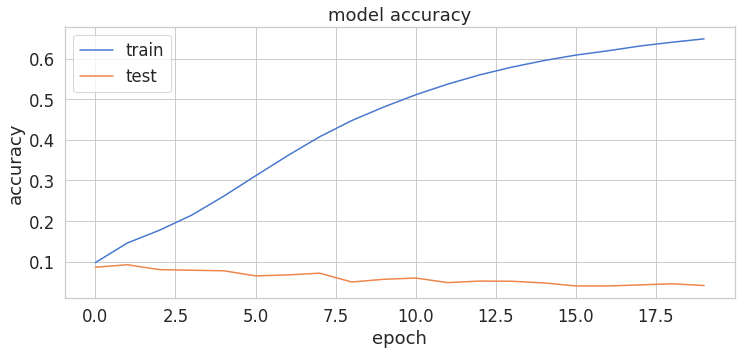

In [15]:
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

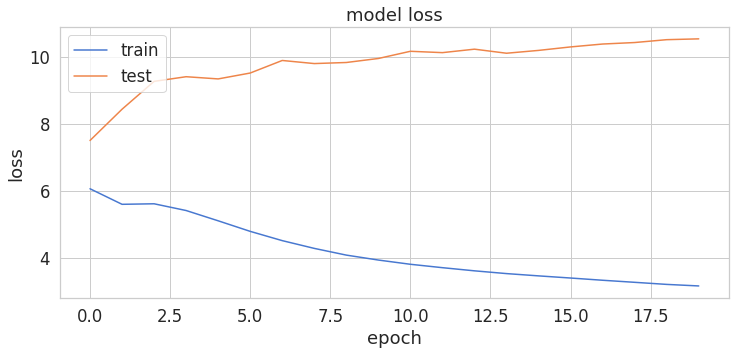

In [16]:
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [17]:
model.save('Wpg222S5L128x1.h5')
pickle.dump(history1, open("history1.p", "wb"))

In [26]:
#Load Model from GitHub
!wget -O Wpg222S5L128x1.h5 https://github.com/Praxis-QR/DeepLearning/blob/main/models/Wpg222S5L128x1.h5?raw=true
!wget -O history.p https://github.com/Praxis-QR/DeepLearning/blob/main/models/history1.p?raw=true

--2022-08-29 12:03:14--  https://github.com/Praxis-QR/DeepLearning/blob/main/models/Wpg222S5L128x1.h5?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Praxis-QR/DeepLearning/raw/main/models/Wpg222S5L128x1.h5 [following]
--2022-08-29 12:03:14--  https://github.com/Praxis-QR/DeepLearning/raw/main/models/Wpg222S5L128x1.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/models/Wpg222S5L128x1.h5 [following]
--2022-08-29 12:03:14--  https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/models/Wpg222S5L128x1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [27]:
model = load_model("Wpg222S5L128x1.h5")
history = pickle.load(open("history.p", "rb"))

In [20]:
# gets text as a list of words and converts it into 
# an array of numbers
def Text2Array(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text):
        try:
            x[0, t, unique_word_index[word]] = 1
        except:
            print('unseen word >> ', word)
        
    return x

In [ ]:
#Text2Array(("This is an upset example").lower().split())

In [21]:
#from an array of probabilities, picks up the indexes of the top 3
#very clever coding indeed
def TopIndices(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [22]:
def getNextWords(text, n=3):
    x = Text2Array(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = TopIndices(preds,n)
    nextWords = []
    for idx in next_indices:
        nextWords.append(unique_words[idx])
    return nextWords

In [23]:
quotes = [
    "It is not a lack of love but a lack of friendship that makes unhappy marriages",
    "That which does not kill us makes us stronger",
    "I'm not upset that you lied to me I'm upset that from now on I can't believe you",
    "And those who were seen dancing were thought to be insane by those who could not hear the music",
    "It is hard enough to remember my opinions without also remembering my reasons for them"
]

In [28]:
for q in quotes:
    seq = q.lower().split()[:5] # picks first 5 words
    print(seq)
    print(getNextWords(seq, 5))
    print()

['it', 'is', 'not', 'a', 'lack']
['of', 'which', 'thing', 'remained', 'like']

['that', 'which', 'does', 'not', 'kill']
['strickland', 'him', 'people', 'her', 'i']

["i'm", 'not', 'upset', 'that', 'you']
unseen word >>  upset
['said', 'are', 'have', 'might', 'could']

['and', 'those', 'who', 'were', 'seen']
['strickland', 'of', 'what', 'not', 'as']

['it', 'is', 'hard', 'enough', 'to']
['know', 'come', 'which', 'love', 'others']



In [29]:
#ignore this cell
#
testPhrase = "that which does not kill"
print(testPhrase)
Xinput = Text2Array(testPhrase.lower().split())
#Xinput
preds = model.predict(Xinput, verbose=0)  # generates an array of probablites for each word
len(preds[0])
x = unique_words[TopIndices(preds[0],5)]
print(x)


that which does not kill
['strickland' 'him' 'people' 'her' 'i']


#Last Execution

In [30]:
!date

Mon Aug 29 12:03:55 UTC 2022


#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself. 
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png) The contents of this website are released under creative commons 